#Transforms and Resampling

This tutorial explains how to apply transforms to images.

In [1]:
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

##Creating and Manipulating Transforms

A number of different spatial transforms are available in SimpleITK.

The simplest is the Identity Transform.  This transform simply returns input points unaltered.

In [37]:
dimension = 2

print('*Identity Transform*')
identity = sitk.Transform(dimension, sitk.sitkIdentity)
print('Dimension: ' + str(identity.GetDimension()))

# Points are always defined in physical space
point = (1.0, 1.0)
def transform_point(transform, point):
    transformed_point = transform.TransformPoint(point)
    print('Point ' + str(point) + ' transformed is ' + str(transformed_point))

transform_point(identity, point)

*Identity Transform*
Dimension: 2
Point (1.0, 1.0) transformed is (1.0, 1.0)


Transform are defined by two sets of parameters, the *Parameters* and *FixedParameters*.  *FixedParameters* are not changed during the optimization process when performing registration.  For the TranslationTransform, the Parameters are the values of the translation Offset.

In [13]:
print('*Translation Transform*')
translation = sitk.TranslationTransform(dimension)

print('Parameters: ' + str(translation.GetParameters()))
print('Offset:     ' + str(translation.GetOffset()))
print('FixedParameters: ' + str(translation.GetFixedParameters()))
transform_point(translation, point)

print('')
translation.SetParameters((3.1, 4.4))
print('Parameters: ' + str(translation.GetParameters()))
transform_point(translation, point)

*Translation Transform*
Parameters: (0.0, 0.0)
Offset:     (0.0, 0.0)
FixedParameters: ()
Point (1.0, 1.0) transformed is (1.0, 1.0)

Parameters: (3.1, 4.4)
Point (1.0, 1.0) transformed is (4.1, 5.4)


The affine transform is capable of representing translations, rotations, shearing, and scaling.

In [17]:
print('*Affine Transform*')
affine = sitk.AffineTransform(dimension)

print('Parameters: ' + str(affine.GetParameters()))
print('FixedParameters: ' + str(affine.GetFixedParameters()))
transform_point(affine, point)

print('')
affine.SetTranslation((3.1, 4.4))
print('Parameters: ' + str(affine.GetParameters()))
transform_point(affine, point)

*Affine Transform*
Parameters: (1.0, 0.0, 0.0, 1.0, 0.0, 0.0)
FixedParameters: (0.0, 0.0)
Point (1.0, 1.0) transformed is (1.0, 1.0)

Parameters: (1.0, 0.0, 0.0, 1.0, 3.1, 4.4)
Point (1.0, 1.0) transformed is (4.1, 5.4)


A number of other transforms exist to represent non-affine deformations, well-behaved rotation in 3D, etc. See the [Transforms](22_Transforms.ipynb) tutorial for more information.

##Applying Transforms to Images

Create a function to display the images that is aware of image spacing.

In [18]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
        
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    
    t = ax.imshow(nda,
            extent=extent,
            interpolation='hamming',
            cmap='gray',
            origin='lower')
    
    if(title):
        plt.title(title)

Create a grid image.

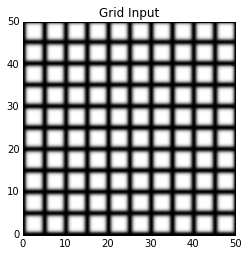

In [19]:
grid = sitk.GridSource(outputPixelType=sitk.sitkUInt16,
    size=(250, 250),
    sigma=(0.5, 0.5),
    gridSpacing=(5.0, 5.0),
    gridOffset=(0.0, 0.0),
    spacing=(0.2,0.2))
myshow(grid, 'Grid Input')

To apply the transform, a resampling operation is required.

Point (1.0, 1.0) transformed is (4.1, 5.6)


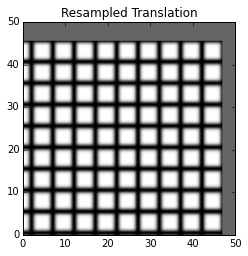

In [21]:
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

translation.SetOffset((3.1, 4.6))
transform_point(translation, point)
resampled = resample(grid, translation)
myshow(resampled, 'Resampled Translation')

What happened?  The translation is positive in both directions.  Why does the output image move down and to the left?  It important to keep in mind that a transform in a resampling operation defines *the transform from the output space to the input space*.

Point (1.0, 1.0) transformed is (-2.1, -3.5999999999999996)


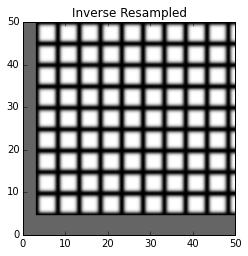

In [22]:
translation.SetOffset(-1*np.array(translation.GetParameters()))
transform_point(translation, point)
resampled = resample(grid, translation)
myshow(resampled, 'Inverse Resampled')

An affine (line preserving) transformation, can perform translation:

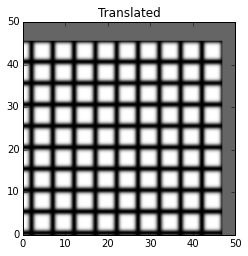

In [27]:
def affine_translate(transform, x_translation, y_translation):
    new_transform = sitk.AffineTransform(transform)
    new_transform.SetTranslation((x_translation, y_translation))
    return new_transform
    
affine = sitk.AffineTransform(dimension)
affine = affine_translate(affine, 3.1, 4.6)
resampled = resample(grid, affine)
myshow(resampled, 'Translated')

or scaling:

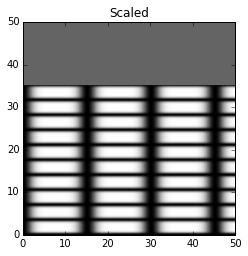

In [40]:
def affine_scale(transform, x_scale, y_scale):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix[0,0] /= x_scale
    matrix[1,1] /= y_scale
    new_transform.SetMatrix(matrix.ravel())
    return new_transform

affine = sitk.AffineTransform(dimension)
affine = affine_scale(affine, 3.0, 0.7)
resampled = resample(grid, affine)
myshow(resampled, 'Scaled')

or rotation:

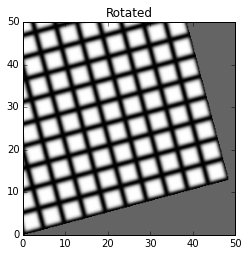

In [45]:
def affine_rotate(transform, degrees):
    parameters = np.array(transform.GetParameters())
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    radians = -np.pi * degrees / 180.
    rotation = np.array([[np.cos(radians), -np.sin(radians)],[np.sin(radians), np.cos(radians)]])
    new_matrix = np.dot(rotation, matrix)
    new_transform.SetMatrix(new_matrix.ravel())
    return new_transform
    
affine = sitk.AffineTransform(dimension)
affine = affine_rotate(affine, 15.0)
resampled = resample(grid, affine)
myshow(resampled, 'Rotated')

or shearing:

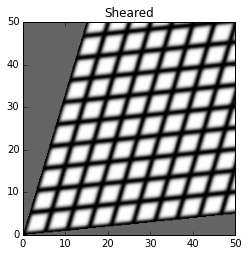

In [50]:
def affine_shear(transform, x_shear, y_shear):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix[0,1] = -x_shear
    matrix[1,0] = -y_shear
    new_transform.SetMatrix(matrix.ravel())
    return new_transform

affine = sitk.AffineTransform(dimension)
affine = affine_shear(affine, 0.3, 0.1)
resampled = resample(grid, affine)
myshow(resampled, 'Sheared')

## Composite Transform

It is possible to compose multiple transform together into a single transform object.  With a composite transform, multiple resampling operations are prevented, so interpolation errors are not accumulated.  For example, an affine transformation that consists of a translation and rotation,

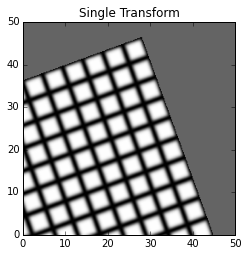

In [53]:
translate = (8.0, 16.0)
rotate = 20.0

affine = sitk.AffineTransform(dimension)
affine = affine_translate(affine, translate[0], translate[1])
affine = affine_rotate(affine, rotate)

resampled = resample(grid, affine)
myshow(resampled, 'Single Transform')

can also be represented with two Transform objects applied in sequence with a Composite Transform,

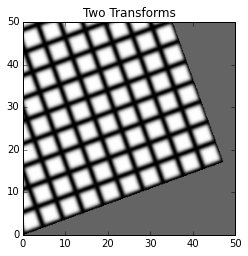

In [56]:
translation = sitk.TranslationTransform(dimension)
translation.SetOffset(-1*np.array(translate))
composite.AddTransform(translation)
affine = sitk.AffineTransform(dimension)
affine = affine_rotate(affine, rotate)

composite.AddTransform(translation)
composite = sitk.Transform(dimension, sitk.sitkComposite)
composite.AddTransform(affine)

resampled = resample(grid, composite)
myshow(resampled, 'Two Transforms')

*Beware*, tranforms are noncommutative -- order matters!

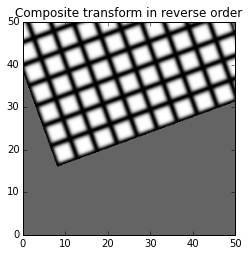

In [57]:
composite = sitk.Transform(dimension, sitk.sitkComposite)
composite.AddTransform(affine)
composite.AddTransform(translation)

resampled = resample(grid, composite)
myshow(resampled, 'Composite transform in reverse order')